# Geospatial Data Visualization
Most of the time we want to plot our data, vector or raster data. We will use two packages: Matplotlib and Mapnik

In [1]:
import os
import shutil
import glob
import numpy as np
import math
from osgeo import gdal, osr, ogr
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib as mpl
#from ospybook.vectorplotter import VectorPlotter
#vp = VectorPlotter(True)
%matplotlib inline
print("GDAL version: %s"%gdal.__version__)

GDAL version: 3.5.1


## Plotting vector data with Matplotlib
The first plot is a collection of geometries containing only one polygon, without holes. The geometries represent the Earth's continents and major islands

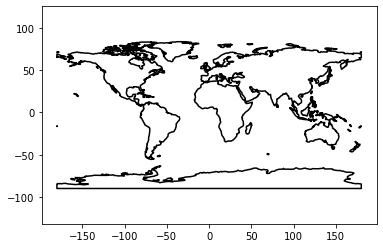

In [2]:
ds = ogr.Open('data/vector/global/ne_110m_land.shp')
lyr = ds.GetLayer(0)
for row in lyr:
    geom = row.geometry()
    ring = geom.GetGeometryRef(0)
    coords = ring.GetPoints()
    x, y = zip(*coords)
    plt.plot(x, y, 'k')
plt.axis('equal')
plt.show()

The next plot is a collection of geometries that represent countries of the World and that may contain single polygons or more than one polygon (multipolygons). In order to visualize them we have to iterate through the polygons and multipolygons and then plot each of them. We use two functions to achieve the result.

In [3]:
def plot_polygon(poly, symbol='k-', **kwargs):
    """Plots a polygon using the given symbol."""
    for i in range(poly.GetGeometryCount()):
        subgeom = poly.GetGeometryRef(i)
        x, y = zip(*subgeom.GetPoints())
        plt.plot(x, y, symbol, **kwargs)
        #plt.fill(x, y, symbol, **kwargs)

In [4]:
def plot_layer(filename, symbol, layer_index=0, **kwargs):
    """Plots an OGR polygon layer using the given symbol."""
    ds = ogr.Open(filename)
    for row in ds.GetLayer(layer_index):
        geom = row.geometry()
        geom_type = geom.GetGeometryType()
        if geom_type == ogr.wkbPolygon:
            plot_polygon(geom, symbol, **kwargs)
        elif geom_type == ogr.wkbMultiPolygon:
            for i in range(geom.GetGeometryCount()):
                subgeom = geom.GetGeometryRef(i)
                plot_polygon(subgeom, symbol, **kwargs)

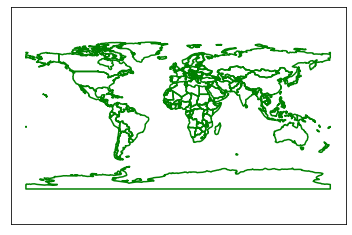

In [5]:
plot_layer('data/vector/global/ne_110m_admin_0_countries.shp', 'g-')
plt.axis('equal')
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.show()

We use two more functions to plot also lines and points in addition to polygongs

In [6]:
def plot_line(line, symbol='k-', **kwargs):
    """Plots a line using the given symbol."""
    x, y = zip(*line.GetPoints())
    plt.plot(x, y, symbol, **kwargs)

In [7]:
def plot_point(point, symbol='ko', **kwargs):
    """Plots a point using the given symbol."""
    x, y = point.GetX(), point.GetY()
    plt.plot(x, y, symbol, **kwargs)

A new version of the plot_layer() function that can draw also lines and points

In [8]:
def plot_layer2(filename, symbol, layer_index=0, **kwargs):
    """Plots an OGR layer using the given symbol."""
    ds = ogr.Open(filename)
    for row in ds.GetLayer(layer_index):
        geom = row.geometry()
        geom_type = geom.GetGeometryType()
        if geom_type == ogr.wkbPolygon:
            plot_polygon(geom, symbol, **kwargs)
        elif geom_type == ogr.wkbMultiPolygon:
            for i in range(geom.GetGeometryCount()):
                subgeom = geom.GetGeometryRef(i)
                plot_polygon(subgeom, symbol, **kwargs)
        elif geom_type == ogr.wkbLineString:
            plot_line(geom, symbol, **kwargs)
        elif geom_type == ogr.wkbMultiLineString:
            for i in range(geom.GetGeometryCount()):
                subgeom = geom.GetGeometryRef(i)
                plot_line(subgeom, symbol, **kwargs)
        elif geom_type == ogr.wkbPoint:
            plot_point(geom, symbol, **kwargs)
        elif geom_type == ogr.wkbMultiPoint:
            for i in range(geom.GetGeometryCount()):
                subgeom = geom.GetGeometryRef(i)
                plot_point(subgeom, symbol, **kwargs)

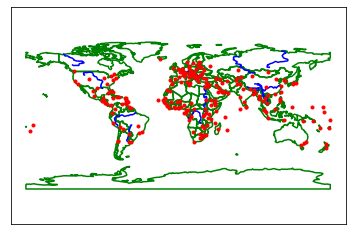

In [9]:
plot_layer2('data/vector/global/ne_110m_admin_0_countries.shp', 'g-')
plot_layer2('data/vector/global/ne_110m_rivers_lake_centerlines.shp', 'b-')
plot_layer2('data/vector/global/ne_110m_populated_places_simple.shp', 'ro', ms=3)
plt.axis('equal')
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.show()

## Plotting raster data with Matplotlib
Plotting raster data is eassier than vector data

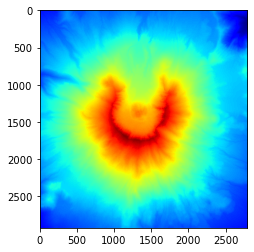

In [10]:
ds = gdal.Open('data/raster/Washington/dem/sthelens_utm.tif')
data = ds.GetRasterBand(1).ReadAsArray()
plt.imshow(data, cmap='jet')
plt.show()

A raster dataset can have bands with different resolutions that can be used to draw an image without using the full resolution to save memory.

In [11]:
def get_overview_data(fn, band_index=1, level=-1):
    """ Returns an array containing data from an overview.
    fn:         path to raster file
    band_index: band number to get overview for
    level:      overview level, where 1 is the highest resolution;
                the coarsest can be retrieved with -1
    """
    ds = gdal.Open(fn)
    band = ds.GetRasterBand(band_index)
    if level > 0:
        ov_band = band.GetOverview(level)
    else:
        num_ov = band.GetOverviewCount()
        ov_band = band.GetOverview(num_ov + level)
    return ov_band.ReadAsArray()

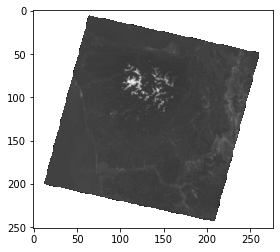

In [12]:
fn = 'data/raster/Landsat/Washington/p047r027_7t20000730_z10_nn10.tif' # raster with only 1 band
data = get_overview_data(fn)
data = np.ma.masked_equal(data, 0) # removes (mask out) pixels that are not part of the image
plt.imshow(data, cmap='gray')
plt.show()

We can modify the pixel values, for example to be within 2 standard deviations, to improve the visualization

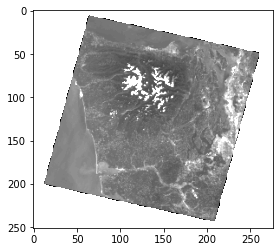

In [13]:
mean = np.mean(data)
std_range = np.std(data) * 2
plt.imshow(data, cmap='gray', vmin=mean - std_range, vmax=mean + std_range)

We can stack three bands, e.g. RGB, into a three-dimensional array

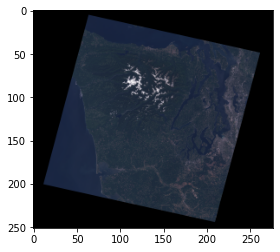

In [14]:
path = 'data/raster/Landsat/Washington/'
red_fn = path + 'p047r027_7t20000730_z10_nn30.tif'
green_fn = path + 'p047r027_7t20000730_z10_nn20.tif'
blue_fn = path + 'p047r027_7t20000730_z10_nn10.tif'
red_data = get_overview_data(red_fn)
green_data = get_overview_data(green_fn)
blue_data = get_overview_data(blue_fn)
data = np.dstack((red_data, green_data, blue_data))
plt.imshow(data)

We can improve the visualization by stretching the three bands one by one using the following function

In [15]:
def stretch_data(data, num_stddev):
    """Returns the data with a standard deviation stretch applied.
    data - array containing data to stretch
    num_stddev - number of standard deviations to use
    """
    mean = np.mean(data)
    std_range = np.std(data) * 2
    new_min = max(mean - std_range, np.min(data))
    new_max = min(mean + std_range, np.max(data))
    clipped_data = np.clip(data, new_min, new_max)
    return clipped_data / (new_max - new_min)

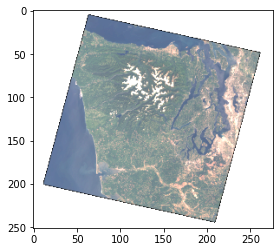

In [16]:
red_data = stretch_data(get_overview_data(red_fn), 2)
green_data = stretch_data(get_overview_data(green_fn), 2)
blue_data = stretch_data(get_overview_data(blue_fn), 2)
alpha = np.where(red_data + green_data + blue_data > 0, 1, 0)
data = np.dstack((red_data, green_data, blue_data, alpha))
plt.imshow(data)

Digital elevation models can be visualized as 3D data. We have to define the x and y coordinates and then use the values in the DEM to draw a 3D image

In [17]:
ds = gdal.Open('data/raster/Washington/dem/sthelens_utm.tif')
band = ds.GetRasterBand(1)
ov_band = band.GetOverview(band.GetOverviewCount() - 3)
data = ov_band.ReadAsArray()

In [18]:
geotransform = ds.GetGeoTransform()
minx = geotransform[0]
maxy = geotransform[3]
maxx = minx + ov_band.XSize * geotransform[1]
miny = maxy + ov_band.YSize * geotransform[5]
x = np.arange(minx, maxx, geotransform[1])
y = np.arange(maxy, miny, geotransform[5])
x, y = np.meshgrid(x[:ov_band.XSize], y[:ov_band.YSize])

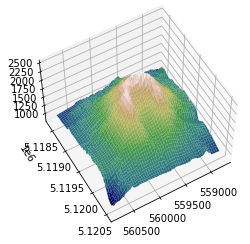

In [19]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, data, cmap='gist_earth', lw=0)
ax.view_init(elev=55, azim=60) # ground level -> elevation=0, from above -> elevation=90
#plt.axis('off')

## Mapnik (tbd)